# Task 7: Sales Forecasting

This notebook focuses on forecasting Walmart sales using historical data.  
here i will prepare the dataset, create time-based features, train regression models, and evaluate predictions.

### - Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


## 1. Introduction
- Goal: Predict future sales based on historical Walmart sales data.  
- Dataset: `train.csv`, `test.csv`, `features.csv`, `stores.csv`.

We load the Walmart Sales Forecast dataset and merge train, test, features, and stores data.

In [2]:

train = pd.read_csv("walmart-sales-forecast/train.csv")
test = pd.read_csv("walmart-sales-forecast/test.csv")
features = pd.read_csv("walmart-sales-forecast/features.csv")
stores = pd.read_csv("walmart-sales-forecast/stores.csv")



## 2. Data Preprocessing
- Handle missing values.  
- Drop unnecessary columns (like unused MarkDown features).  
- Convert categorical variables into numeric (e.g., `IsHoliday`, `Type`).


In [3]:
for df in [train, features, test]:
    df["Date"] = pd.to_datetime(df["Date"])

features.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis =1 , inplace = True )

df = (train.merge(features, on=["Store", "Date", "IsHoliday"], how="left").merge(stores, on="Store", how="left"))
df_test = (test.merge(features, on=["Store", "Date", "IsHoliday"], how="left").merge(stores, on="Store", how="left"))

# convert categorical features such as: IsHoliday into numerical features such true: 1, false: 0
df['IsHoliday'] = df['IsHoliday'].map({True:1, False:0})
df['Type'].value_counts()
df['Type'] = df['Type'].map({'A': 1, 'B': 2, 'C': 3})

In [4]:


# Load dataset (update path if needed)
df = pd.read_csv("train.csv")

print("Missing values before handling:\n")
print(df.isnull().sum())

# Fill numeric columns (int/float) with median
for col in df.select_dtypes(include=["float64", "int64"]).columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Fill categorical columns (object) with mode
for col in df.select_dtypes(include=["object"]).columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after handling:\n")
print(df.isnull().sum())


Missing values before handling:

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

Missing values after handling:

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


## 3. Data Loading & Exploration
- In this step, we load all datasets, merge them, and check the structure of the data.  
- We will also perform initial exploration with `.info()`, `.head()`, and `.describe()`.


In [5]:
df.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [7]:
df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


## 4. Feature Engineering (Time-based Features)
- Extract date parts: **day, month, year**.
- Create **lag features** (sales from previous weeks).
- Add **rolling averages** to capture trends.

In [8]:

# Make sure Date is datetime
df["Date"] = pd.to_datetime(df["Date"])

def make_time_features(fe):
    d = fe.copy()
    d["Year"] = d["Date"].dt.year
    d["Month"] = d["Date"].dt.month
    d["Week"] = d["Date"].dt.isocalendar().week.astype(int)
    d["Day"] = d["Date"].dt.day
    
    # Create lag features
    for L in [1, 2, 4, 8, 13, 26, 52]:
        d[f"lag_{L}"] = d["Weekly_Sales"].shift(L)
    
    # Rolling averages
    d["roll4"] = d["Weekly_Sales"].shift(1).rolling(4).mean()
    d["roll13"] = d["Weekly_Sales"].shift(1).rolling(13).mean()
    
    return d.dropna()

# Apply function
df_train = make_time_features(df)

# Pick one Store & Dept
store_id, dept_id = 1, 1
data = df_train[(df_train.Store == store_id) & (df_train.Dept == dept_id)].copy()


## - Average Weekly Sales by Store

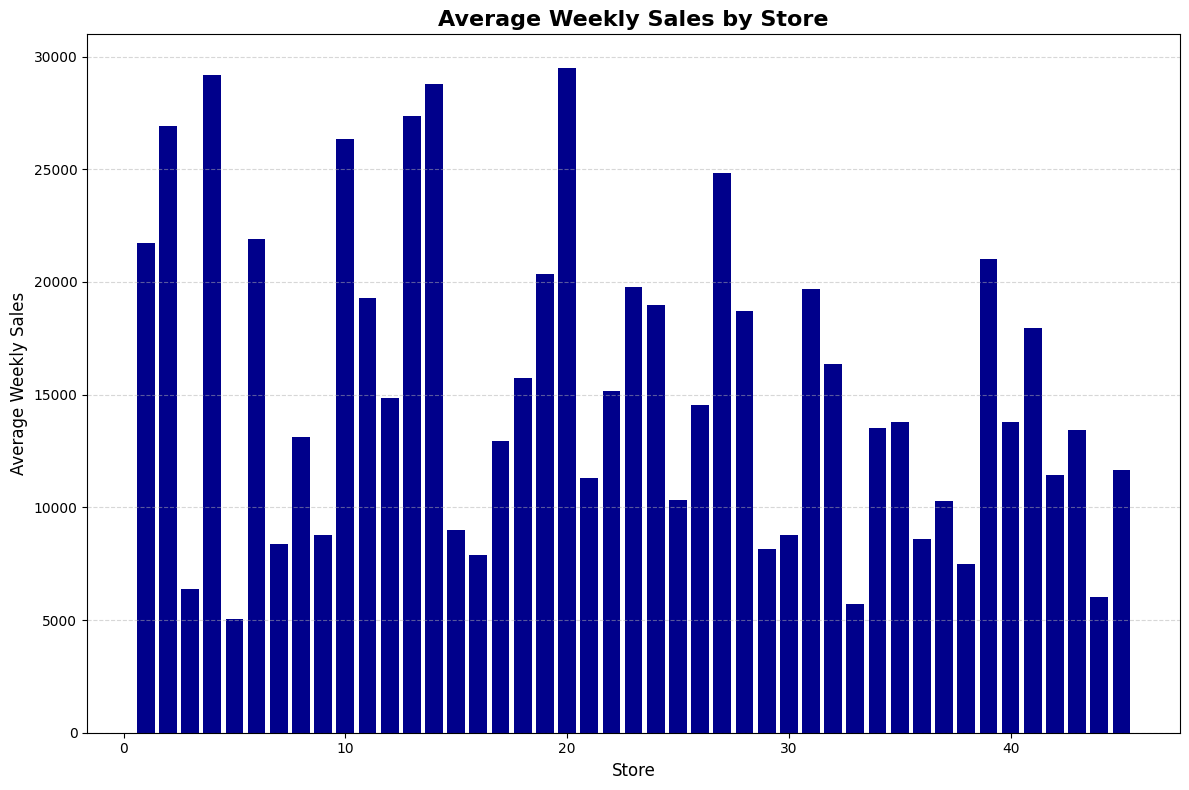

In [55]:
avg_sales = df.groupby('Store')["Weekly_Sales"].mean()

plt.figure(figsize=(12, 8))
plt.bar(avg_sales.index, avg_sales.values, color="darkblue")  

plt.title("Average Weekly Sales by Store", fontsize=16, fontweight='bold')
plt.xlabel("Store", fontsize=12)
plt.ylabel("Average Weekly Sales", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### - Seasonal Decomposition of Weekly Sales (Additive Model, Period = 30)

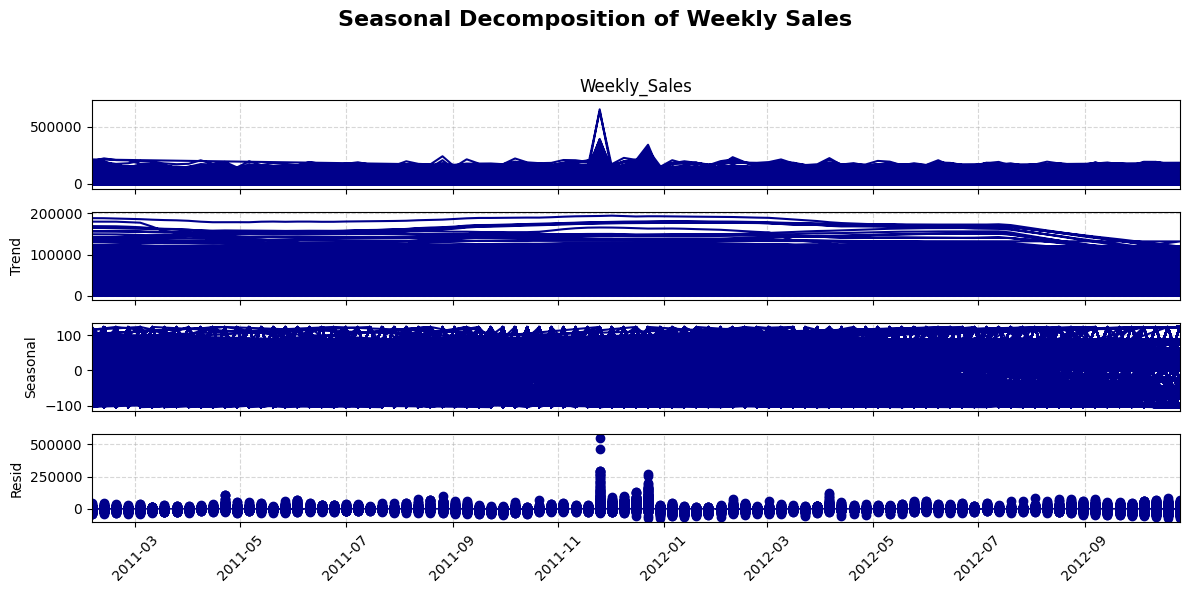

In [53]:


# Perform seasonal decomposition
decomp = seasonal_decompose(df_train.set_index("Date")["Weekly_Sales"], 
                            model="additive", 
                            period=30)

# Create the plot
fig = decomp.plot()
fig.set_size_inches(12, 6)
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color("darkblue")
        line.set_linewidth(1.5)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("Seasonal Decomposition of Weekly Sales", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 5. Regression Models (Forecasting)
We apply regression-based models to forecast sales:
- **Linear Regression** (baseline).


In [11]:
train_df, valid_df = data.iloc[:-12], data.iloc[-12:]
features = [c for c in data.columns if c not in ["Date","Weekly_Sales","Store","Dept"]]

X_train, y_train = train_df[features], train_df.Weekly_Sales
X_valid, y_valid = valid_df[features], valid_df.Weekly_Sales

In [12]:

model_lg = LinearRegression().fit(X_train, y_train)
pred_lg = model_lg.predict(X_valid)
mae_lg = mean_absolute_error(y_valid, pred_lg)
rmse_lg = mean_squared_error(y_valid, pred_lg)
rmse_lg = np.sqrt(mae_lg)

print(f"Linear Regression MAE: {mae_lg:.2f}, RMSE: {rmse_lg:.2f}")

Linear Regression MAE: 1511.57, RMSE: 38.88


- **XG Boost Model**

In [13]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=800, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_valid)
mae_xgb = mean_absolute_error(y_valid, pred_xgb)
rmse_xgb = mean_squared_error(y_valid, pred_xgb)
rmse_xgb = np.sqrt(mae_xgb)

print(f"XGBoost MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")

XGBoost MAE: 1305.94, RMSE: 36.14


- **LightGBM model**

In [60]:
from lightgbm import LGBMRegressor

X = df_train.drop(columns=["Date", "Weekly_Sales"])   # only numeric features
y = df_train["Weekly_Sales"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)


lgb = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=7,      
    num_leaves=31,      
    min_data_in_leaf=20,  
    random_state=42
)
lgb.fit(X_train, y_train)

pred_lgb = lgb.predict(X_valid)

mae_lgb = mean_absolute_error(y_valid, pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_valid, pred_lgb))

print(f"LightGBM MAE: {mae_lgb:.2f}, RMSE: {rmse_lgb:.2f}")

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 337214, number of used features: 16
[LightGBM] [Info] Start training from score 15978.650053
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
LightGBM MAE: 1470.87, RMSE: 3953.86


## Actual vs Predicted

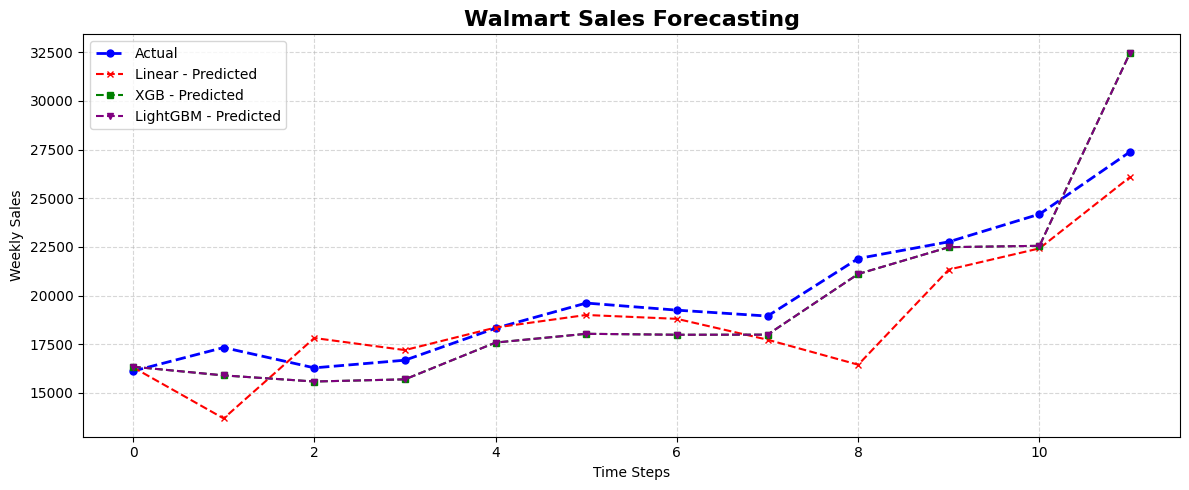

In [15]:
plt.figure(figsize=(12, 5))

# Actual values
plt.plot(y_valid.values[:50],
         label="Actual",
         color="blue",
         linestyle="--",
         linewidth=2,
         marker='o',
         markersize=5)

# Linear Regression predictions
plt.plot(pred_lg[:50],
         label="Linear - Predicted",
         color="red",
         linestyle="--",
         linewidth=1.5,
         marker='x',
         markersize=5)

# XGBoost predictions
plt.plot(pred_xgb[:50],
         label="XGB - Predicted",
         color="green",
         linestyle="--",
         linewidth=1.5,
         marker='s',
         markersize=5)

# LightGBM predictions
plt.plot(pred_xgb[:50],
         label="LightGBM - Predicted",
         color="purple",
         linestyle="--",
         linewidth=1.5,
         marker='v',
         markersize=5)

plt.xlabel("Time Steps", fontsize=10)
plt.ylabel("Weekly Sales", fontsize=10)
plt.title("Walmart Sales Forecasting", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [19]:
last = df.iloc[-1].copy()
next_date = last.Date + pd.Timedelta(days=7)

for L in [1,2,4,8,13,26,52]:
    last[f"lag_{L}"] = df.Weekly_Sales.iloc[-L]
last["roll4"] = df.Weekly_Sales.iloc[-4:].mean()
last["roll13"] = df.Weekly_Sales.iloc[-13:].mean()

last["Date"] = next_date
last["Year"] = next_date.year
last["Month"] = next_date.month
last["Week"] = next_date.isocalendar().week
last["Day"] = next_date.day

X_next = last[features].values.reshape(1,-1)
next_pred = xgb.predict(X_next)[0]

print("Forecast for next week:", next_date.date(), "->", round(next_pred,2))

Forecast for next week: 2012-11-02 -> 18122.46


## Separate Actual vs Predicted plots
- Linear Regression
- XGBoost
- LightGBM

In [32]:
target = "Weekly_Sales"
X = df_train.drop(columns=["Date", "Weekly_Sales"])
y = df_train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



#### 1. Linear Regression:

In [47]:
# 1. Linear Regression

# Create and train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)


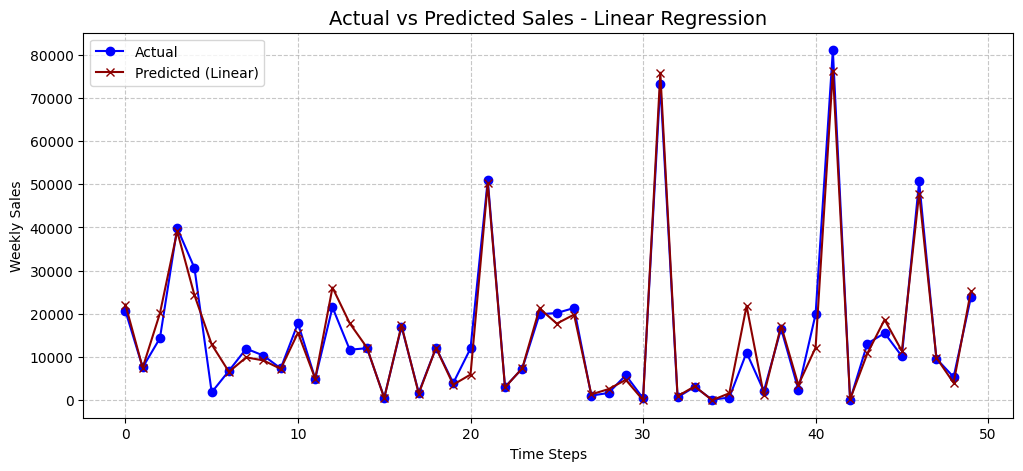

In [49]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:50], label="Actual", color="blue", marker='o')
plt.plot(y_pred_lr[:50], label="Predicted (Linear)", color="darkred", marker='x')
plt.title("Actual vs Predicted Sales - Linear Regression", fontsize=14)
plt.xlabel("Time Steps")
plt.ylabel("Weekly Sales")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

#### 2. XG Boost

In [37]:

# Train the model
xgb = XGBRegressor(n_estimators=800, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

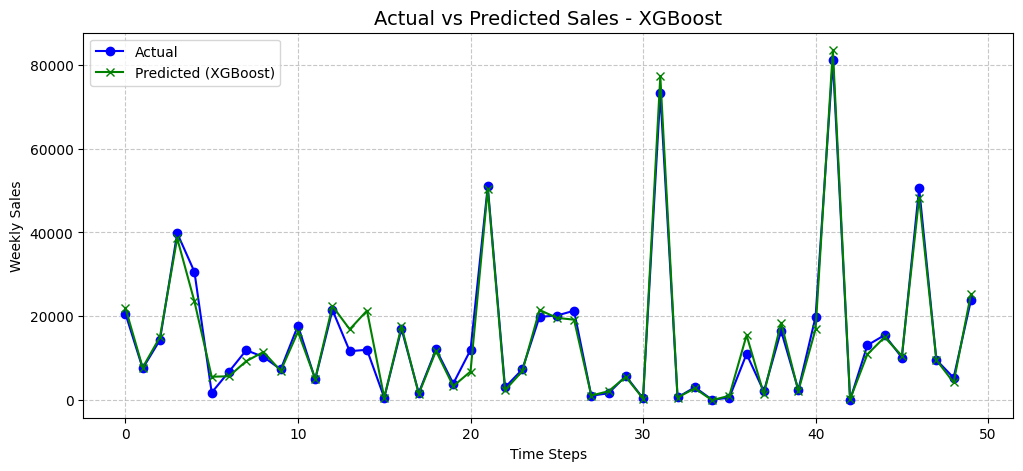

In [38]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:50], label="Actual", color="blue", marker='o')
plt.plot(y_pred_xgb[:50], label="Predicted (XGBoost)", color="green", marker='x')
plt.title("Actual vs Predicted Sales - XGBoost", fontsize=14)
plt.xlabel("Time Steps")
plt.ylabel("Weekly Sales")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

#### 3. LightGBM

In [41]:

import lightgbm as lgb
# Train model
lgbm = LGBMRegressor(n_estimators=800, learning_rate=0.05, max_depth=6, random_state=42)
lgbm.fit(X_train, y_train)

# Predict
y_pred_lgb = lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 337214, number of used features: 16
[LightGBM] [Info] Start training from score 15978.650053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

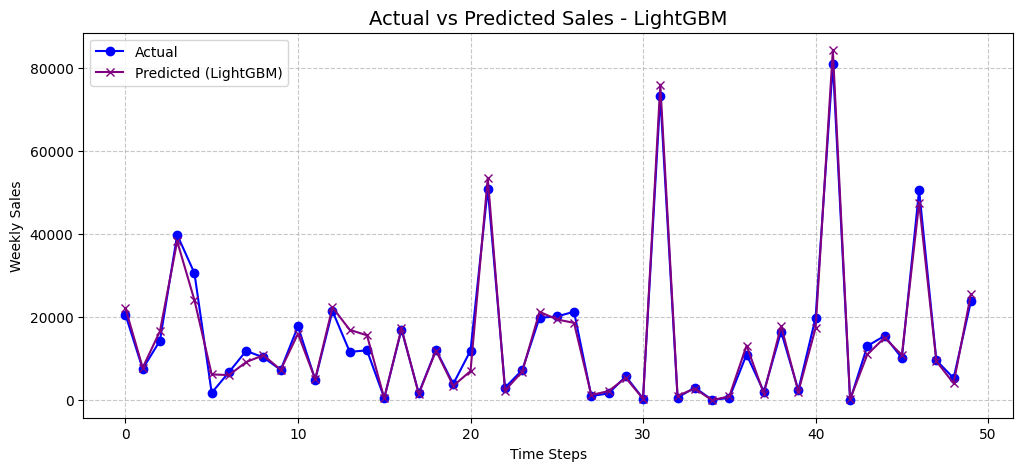

In [51]:
# Make predictions with LightGBM
y_pred_lgbm = lgbm.predict(X_test)

# Then plot
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:50], label="Actual", color="blue", marker='o')
plt.plot(y_pred_lgbm[:50], label="Predicted (LightGBM)", color="purple", marker='x')
plt.title("Actual vs Predicted Sales - LightGBM", fontsize=14)
plt.xlabel("Time Steps")
plt.ylabel("Weekly Sales")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

## Time Series Forecasting with Rolling Averages, Seasonal Decomposition, and XGBoost

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb

# Pick one store & department (example: Store 1, Dept 1)
store_id, dept_id = 1, 1
data = df[(df.Store == store_id) & (df.Dept == dept_id)].copy()
data = data.set_index("Date").sort_index()

# Rolling averages
data["roll4"] = data["Weekly_Sales"].rolling(4).mean()
data["roll13"] = data["Weekly_Sales"].rolling(13).mean()

# Seasonal decomposition (weekly data assumed)
decomp = seasonal_decompose(data["Weekly_Sales"], model="additive", period=52)
data["trend"] = decomp.trend
data["seasonal"] = decomp.seasonal

# Drop missing due to rolling/decomposition
data = data.dropna()

# Define features
base_features = ["roll4","roll13","trend","seasonal","IsHoliday"]
extra_features = ["Temperature","Fuel_Price","CPI","Unemployment","Size"]

# Keep only columns that exist in data
features = base_features + [col for col in extra_features if col in data.columns]

X = data[features]
y = data["Weekly_Sales"]

# Time-aware train-test split (train = first 80%, test = last 20%)
split = int(len(data) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# XGBoost model
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Bonus Task - XGBoost RMSE: {rmse:.2f}")


Bonus Task - XGBoost RMSE: 8990.66


## 7. Advanced Analysis (Bonus)
- Rolling averages visualization.
- Seasonal decomposition to show **trend, seasonality, and residuals**.

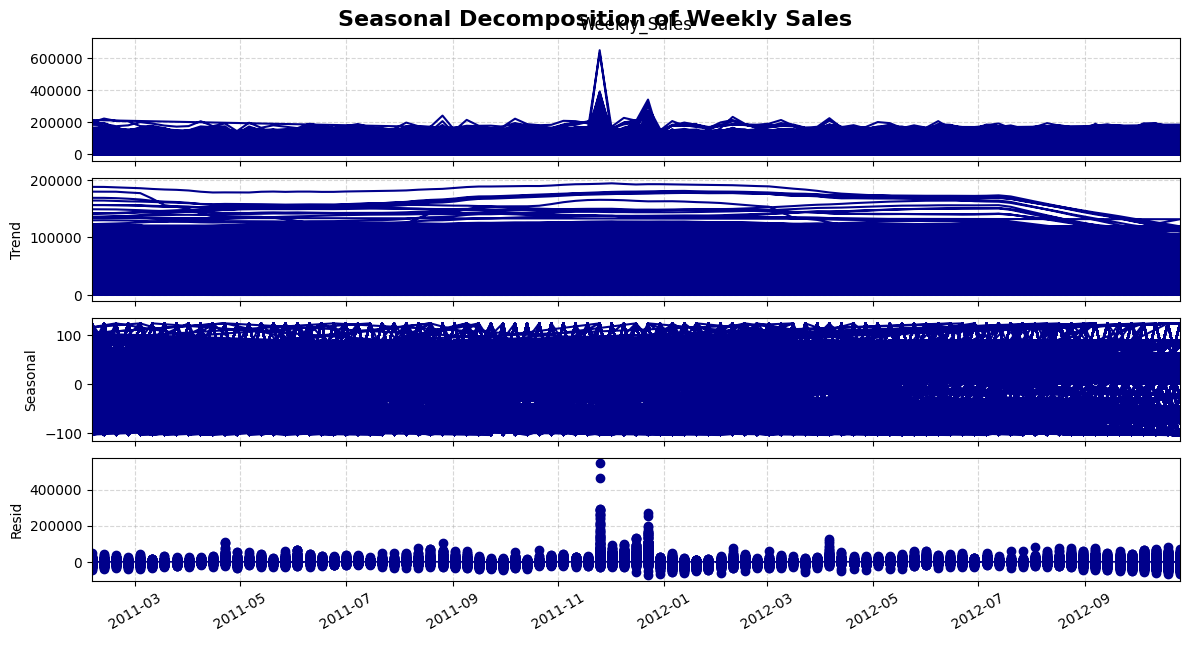

In [57]:


fig = decomp.plot()
fig.set_size_inches(12, 6)
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color("darkblue")
        line.set_linewidth(1.5)  
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel(" ")  
    ax.tick_params(axis='x', rotation=30)  

fig.suptitle("Seasonal Decomposition of Weekly Sales", fontsize=16, fontweight='bold',y=1)
plt.show()


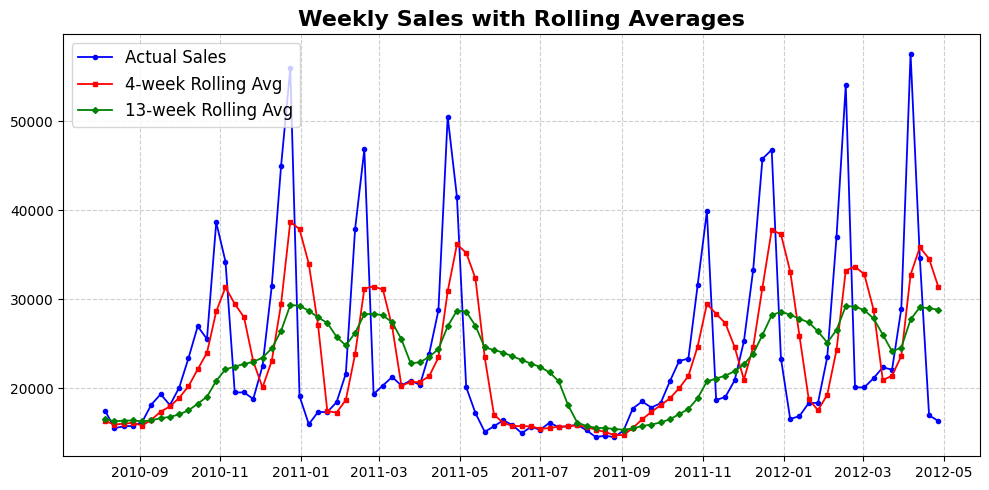

In [29]:
plt.figure(figsize=(10, 5))

plt.plot(data.index, data["Weekly_Sales"], 
         label="Actual Sales", 
         color="blue", 
         linewidth=1.3, 
         marker='o', 
         markersize=3)

plt.plot(data.index, data["roll4"], 
         label="4-week Rolling Avg", 
         color="red", 
         linewidth=1.3, 
         marker='s', 
         markersize=3)

plt.plot(data.index, data["roll13"], 
         label="13-week Rolling Avg", 
         color="green", 
         linewidth=1.3, 
         marker='D', 
         markersize=3)

plt.legend(fontsize=12)
plt.title("Weekly Sales with Rolling Averages", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### Feature Engineering (Time-based Features)
- Graph: Rolling averages plot

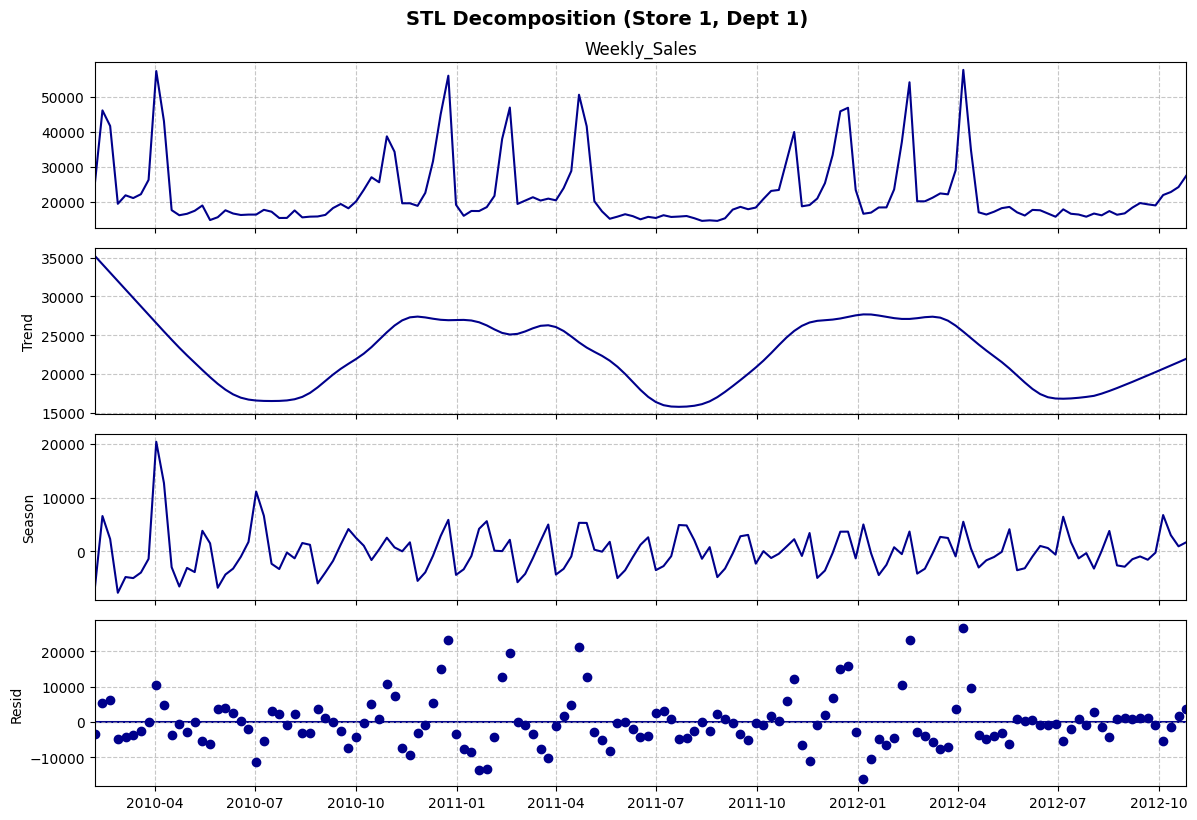

In [30]:

from statsmodels.tsa.seasonal import STL

# Pick one Store & Dept
store_id, dept_id = 1, 1
sample_series = df[(df.Store == store_id) & (df.Dept == dept_id)][["Date", "Weekly_Sales"]]

# Set datetime index
sample_series = sample_series.set_index("Date").sort_index()

# STL decomposition (13 weeks ~ 1 quarter)
stl = STL(sample_series["Weekly_Sales"], period=13)
result = stl.fit()

plt.rcParams.update({'figure.figsize': (12,8)})
fig = result.plot()
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color("darkblue")  
    ax.grid(True, linestyle="--", alpha=0.7)  

plt.suptitle(f"STL Decomposition (Store {store_id}, Dept {dept_id})", fontsize=14, y=1.02 ,fontweight='bold')
plt.show()


## 8. Save Processed Data for Future Use & Load Saved Data


In [31]:
import joblib
joblib.dump(data, 'task7_Sales_Forecasting.pkl')
import os
print(os.getcwd())

C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Scripts


## Task Completion Checklist
-  Predicted future sales based on historical data  
-  Created time-based features (day, month, lag values)  
-  Applied regression models (Linear Regression, XGBoost, LightGBM)  
-  Plotted actual vs. predicted sales  
-  Used rolling averages & seasonal decomposition  

In [73]:
df_train.to_csv(r"E:\Downloads\walmart_sales_processed.csv", index=False)
print(" File saved to E:\\Downloads")

 File saved to E:\Downloads


In [74]:
import pandas as pd

df_loaded = pd.read_csv(r"E:\Downloads\walmart_sales_processed.csv")
print(df_loaded.head())


   Store  Dept        Date  Weekly_Sales  IsHoliday  Year  Month  Week  Day  \
0      1     1  2011-02-04      21665.76      False  2011      2     5    4   
1      1     1  2011-02-11      37887.17       True  2011      2     6   11   
2      1     1  2011-02-18      46845.87      False  2011      2     7   18   
3      1     1  2011-02-25      19363.83      False  2011      2     8   25   
4      1     1  2011-03-04      20327.61      False  2011      3     9    4   

      lag_1     lag_2     lag_4     lag_8    lag_13    lag_26    lag_52  \
0  18461.18  17341.47  15984.24  31497.65  34238.88  17508.41  24924.50   
1  21665.76  18461.18  17359.70  44912.86  19549.39  15536.40  46039.49   
2  37887.17  21665.76  17341.47  55931.23  19552.84  15740.13  41595.55   
3  46845.87  37887.17  18461.18  19124.58  18820.29  15793.87  19403.54   
4  19363.83  46845.87  21665.76  15984.24  22517.56  16241.78  21827.90   

        roll4        roll13  
0  17286.6475  25791.682308  
1  18707.0275 